/tmp/ipython-input-3936858332.py:232: RuntimeWarning: All-NaN slice encountered
  med = np.nanmedian(filled)
/tmp/ipython-input-3936858332.py:445: RuntimeWarning: All-NaN slice encountered
  med = np.nanmedian(vis)


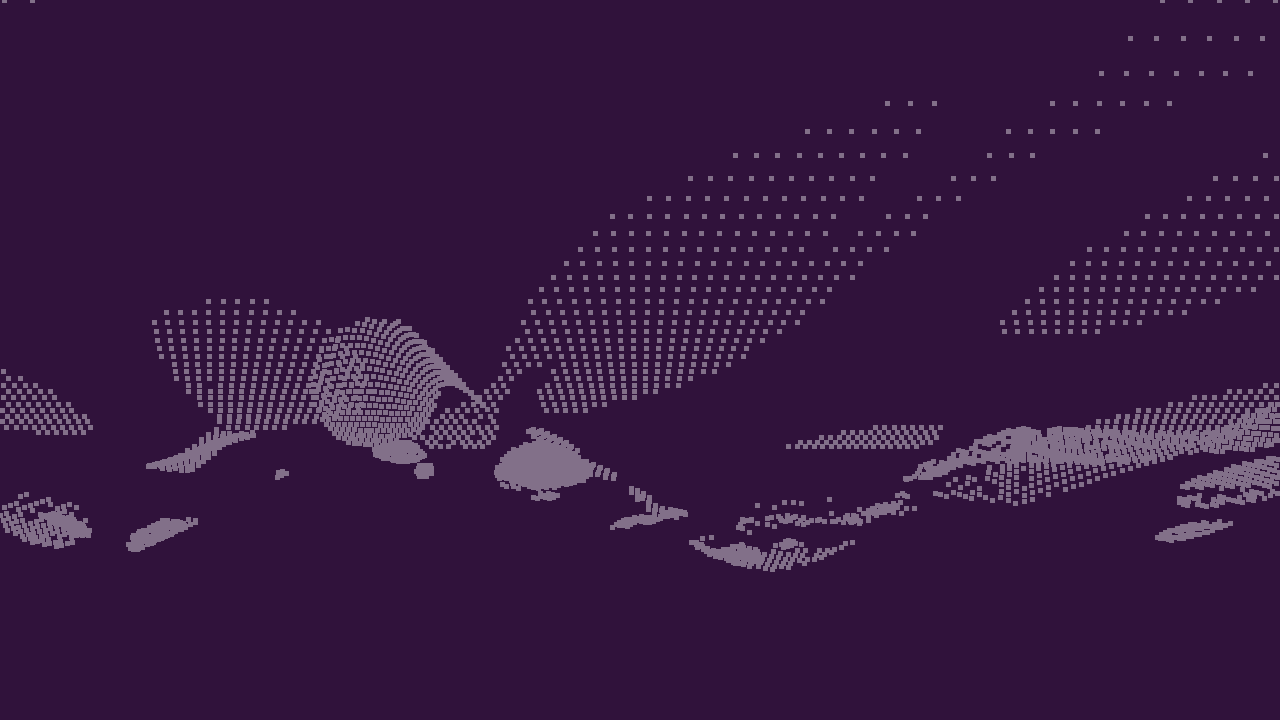

In [1]:
import numpy as np
import cv2

# ----------------------------
# Utility: camera + projection
# ----------------------------
def look_at(eye, target, up=np.array([0, 0, 1.0], dtype=np.float32)):
    """Returns world->camera rotation R and translation t (so X_cam = R*(X_world - eye))."""
    eye = eye.astype(np.float32)
    target = target.astype(np.float32)
    up = up.astype(np.float32)

    f = target - eye
    f = f / (np.linalg.norm(f) + 1e-8)

    r = np.cross(f, up)
    r = r / (np.linalg.norm(r) + 1e-8)

    u = np.cross(r, f)
    u = u / (np.linalg.norm(u) + 1e-8)

    # Camera coordinates: x right, y down (we'll handle sign), z forward
    # Standard "look-at" with z forward: R rows are [r; u; f]
    R = np.stack([r, u, f], axis=0).astype(np.float32)
    t = -R @ eye
    return R, t

def project_points(K, R, t, Pw):
    """Pw: (N,3) world points. Returns pixel coords (N,2) and depth z_cam (N,)."""
    Pc = (R @ Pw.T).T + t  # (N,3)
    z = Pc[:, 2]
    # avoid division by zero/behind camera
    valid = z > 1e-3
    x = Pc[valid, 0] / z[valid]
    y = Pc[valid, 1] / z[valid]
    uv = (K @ np.stack([x, y, np.ones_like(x)], axis=0)).T[:, :2]
    return uv, z[valid], valid

# ----------------------------
# Ocean surface model (height field)
# ----------------------------
def gerstner_like_height(X, Y, waves, t=0.0):
    """
    Simple multi-sine height field (not full Gerstner displacement, but good for depth-map synthesis).
    waves: list of dicts with keys: amp, wavelength, direction (rad), phase, speed
    """
    H = np.zeros_like(X, dtype=np.float32)
    for w in waves:
        A = float(w.get("amp", 0.5))
        lam = float(w.get("wavelength", 12.0))
        theta = float(w.get("direction", 0.0))
        phase = float(w.get("phase", 0.0))
        speed = float(w.get("speed", 4.0))  # m/s-ish
        k = 2.0 * np.pi / (lam + 1e-6)
        # direction unit vector in XY
        dx, dy = np.cos(theta), np.sin(theta)
        # traveling wave argument
        arg = k * (dx * X + dy * Y) - (k * speed) * t + phase
        H += A * np.sin(arg).astype(np.float32)
    return H

def breaking_steepness_mask(X, Y, H, shore_y=0.0, zone=(2.0, 35.0), thresh=0.55):
    """
    Heuristic: breaking more likely nearshore and where local slope is high.
    """
    # slope magnitude
    dHx, dHy = np.gradient(H, X[0, 1] - X[0, 0], Y[1, 0] - Y[0, 0])
    slope = np.sqrt(dHx**2 + dHy**2)

    # nearshore weighting (water is at y > shore_y, beach at y < shore_y)
    dist_to_shore = np.maximum(0.0, Y - shore_y)
    w = np.exp(-((dist_to_shore - zone[0]) / (zone[1] + 1e-6))**2)

    mask = (slope * w) > thresh
    return mask.astype(np.uint8)

def runup_height_on_beach(X, Y, shore_y=0.0, runup_params=None):
    """
    Add shallow "water sheet" on beach (Y < shore_y), shaped as smooth tongues.
    """
    if runup_params is None:
        runup_params = {}
    n_tongues = int(runup_params.get("n_tongues", 6))
    max_reach = float(runup_params.get("max_reach_m", 6.0))  # how far onto beach (meters)
    thickness = float(runup_params.get("thickness_m", 0.12)) # apparent height above beach
    smooth = float(runup_params.get("smooth_m", 1.2))
    rng = np.random.default_rng(int(runup_params.get("seed", 123)))

    beach_mask = (Y < shore_y).astype(np.float32)
    if beach_mask.max() == 0:
        return np.zeros_like(X, dtype=np.float32)

    # Base decay: water sheet decays inland
    inland = np.clip((shore_y - Y) / (max_reach + 1e-6), 0.0, 1.0)
    base = thickness * np.exp(-(inland * 3.5)**2) * beach_mask

    # Add tongues (gaussian blobs elongated along shore-normal)
    runup = base.copy()
    x_min, x_max = X.min(), X.max()

    for _ in range(n_tongues):
        cx = rng.uniform(x_min, x_max)
        reach = rng.uniform(0.4 * max_reach, max_reach)
        w_x = rng.uniform(0.6, 2.0) * smooth
        w_y = rng.uniform(0.8, 2.8) * smooth

        # center inland at some distance from shoreline
        cy = shore_y - rng.uniform(0.2 * reach, reach)
        blob = np.exp(-((X - cx) ** 2) / (2 * w_x**2) - ((Y - cy) ** 2) / (2 * w_y**2))
        blob *= thickness * rng.uniform(0.4, 1.0)
        runup = np.maximum(runup, blob * beach_mask)

    return runup.astype(np.float32)

# ----------------------------
# Rasterize to depth map (z-buffer)
# ----------------------------
def render_depth_from_heightfield(
    X, Y, Z,
    K, R, t,
    out_h=720, out_w=1280,
    z_far=300.0
):
    """
    Render heightfield points as a depth map using a simple z-buffer.
    Depth is z_cam (meters) along camera forward axis.
    """
    Pw = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1).astype(np.float32)
    uv, z, valid = project_points(K, R, t, Pw)
    uv = uv.astype(np.int32)

    depth = np.full((out_h, out_w), z_far, dtype=np.float32)

    # Keep only points that land in image
    inside = (
        (uv[:, 0] >= 0) & (uv[:, 0] < out_w) &
        (uv[:, 1] >= 0) & (uv[:, 1] < out_h)
    )
    uv_in = uv[inside]
    z_in = z[inside]

    # Z-buffer: nearest depth wins
    # Sort by depth ascending so first write is nearest; then use a visited mask.
    order = np.argsort(z_in)
    uv_s = uv_in[order]
    z_s = z_in[order]

    visited = np.zeros((out_h, out_w), dtype=np.uint8)
    for (u, v), zz in zip(uv_s, z_s):
        if visited[v, u] == 0:
            depth[v, u] = zz
            visited[v, u] = 1

    # Fill holes a bit (inpainting) for realism
    holes = (depth >= z_far - 1e-3).astype(np.uint8)
    if holes.mean() < 0.95:
        depth_norm = depth.copy()
        # OpenCV inpaint needs 8-bit; inpaint on a normalized depth proxy
        dmin = np.percentile(depth_norm[depth_norm < z_far], 2)
        dmax = np.percentile(depth_norm[depth_norm < z_far], 98)
        depth_u8 = np.clip((depth_norm - dmin) / (dmax - dmin + 1e-6) * 255, 0, 255).astype(np.uint8)
        depth_u8 = cv2.inpaint(depth_u8, holes, 3, cv2.INPAINT_TELEA)
        depth = dmin + (depth_u8.astype(np.float32) / 255.0) * (dmax - dmin + 1e-6)

    return depth

# ----------------------------
# Realism: noise, distortion, occlusions
# ----------------------------
def add_sensor_artifacts(depth, rng, params=None):
    """
    Adds: range noise, speckle, quantization bands, dropout, slight rolling-shutter warp.
    """
    if params is None:
        params = {}

    d = depth.copy().astype(np.float32)

    # Depth-dependent gaussian noise (more noise far away)
    sigma_near = float(params.get("sigma_near", 0.01))
    sigma_far = float(params.get("sigma_far", 0.18))
    dmin, dmax = np.percentile(d, 5), np.percentile(d, 95)
    alpha = np.clip((d - dmin) / (dmax - dmin + 1e-6), 0, 1)
    sigma = sigma_near + alpha * (sigma_far - sigma_near)
    d += rng.normal(0.0, sigma, size=d.shape).astype(np.float32)

    # Speckle (multiplicative) noise
    speckle = float(params.get("speckle", 0.012))
    d *= (1.0 + rng.normal(0.0, speckle, size=d.shape).astype(np.float32))

    # Quantization (like limited depth resolution)
    q = float(params.get("quant_step_m", 0.02))
    d = np.round(d / q) * q

    # Random dropout pixels
    drop = float(params.get("dropout_prob", 0.015))
    mask = rng.random(d.shape) < drop
    d[mask] = np.nan

    # Mild row-wise warp (rolling shutter / heat haze proxy)
    h, w = d.shape
    max_shift = int(params.get("row_shift_px", 3))
    if max_shift > 0:
        warped = np.full_like(d, np.nan)
        for y in range(h):
            shift = int(rng.integers(-max_shift, max_shift + 1))
            if shift >= 0:
                warped[y, shift:] = d[y, :w - shift]
            else:
                warped[y, :w + shift] = d[y, -shift:]
        d = warped

    return d

def apply_lens_distortion(depth, K, dist=None):
    """
    Applies radial distortion to the depth image by remapping pixels.
    dist: (k1,k2,p1,p2,k3) OpenCV format.
    """
    if dist is None:
        dist = np.array([-0.12, 0.06, 0.0, 0.0, 0.0], dtype=np.float32)

    h, w = depth.shape
    # Build map from distorted -> undistorted, then remap original to distorted frame
    newK = K.copy()
    map1, map2 = cv2.initUndistortRectifyMap(K, dist, None, newK, (w, h), cv2.CV_32FC1)

    # cv2.remap doesn't like NaNs; temporarily fill and keep a NaN mask
    nanmask = np.isnan(depth)
    filled = depth.copy()
    # fill NaNs with median, fallback to 0.0 if all NaN
    med = np.nanmedian(filled)
    if np.isnan(med):
        med = 0.0
    filled[nanmask] = med

    rem = cv2.remap(filled, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=med)
    rem_nan = cv2.remap(nanmask.astype(np.uint8), map1, map2, interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT, borderValue=1).astype(bool)
    rem[rem_nan] = np.nan
    return rem.astype(np.float32)

def add_occlusions(depth, rng, occ=None):
    """
    Add occlusions: foreground people/gear polygons and sensor invalid blocks.
    """
    if occ is None:
        occ = {}
    d = depth.copy().astype(np.float32)
    h, w = d.shape

    # Big foreground occluder (e.g., person/board)
    n_poly = int(occ.get("n_polygons", 2))
    for _ in range(n_poly):
        cx = int(rng.integers(int(0.05*w), int(0.35*w)))
        cy = int(rng.integers(int(0.45*h), int(0.95*h)))
        rw = int(rng.integers(int(0.06*w), int(0.18*w)))
        rh = int(rng.integers(int(0.10*h), int(0.28*h)))
        pts = np.array([
            [cx - rw, cy - rh],
            [cx + rw, cy - int(0.6*rh)],
            [cx + int(0.7*rw), cy + rh],
            [cx - int(0.9*rw), cy + int(0.7*rh)]
        ], dtype=np.int32)
        cv2.fillPoly(d, [pts], color=np.nan)

    # Random rectangular missing blocks
    n_blocks = int(occ.get("n_blocks", 10))
    for _ in range(n_blocks):
        x0 = int(rng.integers(0, w))
        y0 = int(rng.integers(0, h))
        bw = int(rng.integers(int(0.01*w), int(0.06*w)))
        bh = int(rng.integers(int(0.01*h), int(0.05*h)))
        x1 = np.clip(x0 + bw, 0, w)
        y1 = np.clip(y0 + bh, 0, h)
        d[y0:y1, x0:x1] = np.nan

    return d

# ----------------------------
# Main generator
# ----------------------------
def generate_beach_depth_map(
    out_h=720, out_w=1280,
    # Camera
    cam_height_m=1.7,
    cam_back_m=12.0,        # camera on beach, behind shoreline
    cam_tilt_deg=-9.0,
    fov_deg=70.0,
    # Scene extents (world coordinates)
    x_range=(-35.0, 35.0),
    y_range=(-12.0, 110.0), # y=0 is shoreline; y<0 is beach
    grid_res=(420, 520),    # (Ny, Nx) for rendering points
    # Waves
    wave_params=None,
    sea_level=0.0,
    beach_slope=0.08,
    breaking_type="spilling",   # "spilling" | "plunging" | "surging" (heuristic shaping)
    # Run-up
    runup_params=None,
    # Realism
    seed=7,
):
    """
    Returns:
      depth (H,W) float32 meters along camera forward axis (z_cam), with NaNs for invalid/occluded.
      meta dict with some intermediate masks.
    """
    rng = np.random.default_rng(seed)

    # Camera intrinsics from FOV
    f = 0.5 * out_w / np.tan(np.deg2rad(fov_deg) * 0.5)
    K = np.array([[f, 0, out_w/2],
                  [0, f, out_h/2],
                  [0, 0, 1]], dtype=np.float32)

    # Camera pose: eye on beach at y = -cam_back_m, looking toward sea
    eye = np.array([0.0, -cam_back_m, cam_height_m], dtype=np.float32)
    target = np.array([0.0, 30.0, sea_level], dtype=np.float32)

    # Apply extra tilt by adjusting target Z (simple, effective)
    tilt = np.deg2rad(cam_tilt_deg)
    target[2] = sea_level + np.tan(tilt) * (target[1] - eye[1])

    R, t = look_at(eye, target)

    # World grid
    Ny, Nx = grid_res
    xs = np.linspace(x_range[0], x_range[1], Nx, dtype=np.float32)
    ys = np.linspace(y_range[0], y_range[1], Ny, dtype=np.float32)
    X, Y = np.meshgrid(xs, ys)

    # Beach plane (for y<0): z = sea_level - beach_slope * (-y)
    Z_beach = sea_level - beach_slope * np.maximum(0.0, -Y)

    # Waves (for y>=0)
    if wave_params is None:
        # Default multi-component sea
        wave_params = [
            dict(amp=0.7, wavelength=18.0, direction=np.deg2rad(12), phase=0.3, speed=5.0),
            dict(amp=0.35, wavelength=9.0, direction=np.deg2rad(-18), phase=1.1, speed=3.2),
            dict(amp=0.18, wavelength=5.5, direction=np.deg2rad(35), phase=2.2, speed=2.6),
        ]

    H = gerstner_like_height(X, Y, wave_params, t=0.0)

    # Shoaling nearshore: amplify wave height as approaching shoreline (y -> 0+)
    dist = np.clip(Y / 40.0, 0.0, 1.0)
    shoal = 1.0 + (1.0 - dist) * 0.55
    H *= shoal.astype(np.float32)

    # Breaking shaping (heuristic: sharpen/clip crests differently)
    if breaking_type == "spilling":
        # mild crest clipping
        H = np.tanh(H * 1.2) / 1.2
        steep_thresh = 0.55
    elif breaking_type == "plunging":
        # stronger crest sharpening
        H = np.sign(H) * (np.abs(H) ** 1.15)
        steep_thresh = 0.45
    elif breaking_type == "surging":
        # less foam offshore, stronger near shoreline surge
        H *= (1.0 + 0.25 * np.exp(-(Y / 10.0) ** 2)).astype(np.float32)
        steep_thresh = 0.60
    else:
        steep_thresh = 0.55

    Z_sea = sea_level + H

    # Combine sea + beach
    sea_mask = (Y >= 0.0)
    Z = np.where(sea_mask, Z_sea, Z_beach).astype(np.float32)

    # Run-up water sheet on beach
    runup = runup_height_on_beach(X, Y, shore_y=0.0, runup_params=runup_params)
    Z = np.where(Y < 0.0, np.maximum(Z, Z_beach + runup), Z)

    # Breaking mask (candidate foam/unstable depth regions)
    break_mask = breaking_steepness_mask(X, Y, Z_sea, shore_y=0.0, zone=(2.0, 35.0), thresh=steep_thresh)

    # Render to depth map (camera z)
    depth = render_depth_from_heightfield(X, Y, Z, K, R, t, out_h=out_h, out_w=out_w, z_far=300.0)

    # Convert breaking regions into more invalid/noisy depth (like specular/foam failure)
    # Map break_mask from grid -> image by reprojecting and painting
    Pw = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1).astype(np.float32)
    uv, zc, valid = project_points(K, R, t, Pw)
    uv = uv.astype(np.int32)
    bm = break_mask.ravel().astype(np.uint8)
    bm_valid = bm[valid]
    inside = (
        (uv[:, 0] >= 0) & (uv[:, 0] < out_w) &
        (uv[:, 1] >= 0) & (uv[:, 1] < out_h)
    )
    uv_in = uv[inside]
    bm_in = bm_valid[inside]
    foam_img = np.zeros((out_h, out_w), dtype=np.uint8)
    foam_img[uv_in[:, 1], uv_in[:, 0]] = np.maximum(foam_img[uv_in[:, 1], uv_in[:, 0]], bm_in * 255)
    foam_img = cv2.dilate(foam_img, np.ones((5, 5), np.uint8), iterations=1)

    # In foam: add extra dropout + jitter
    foam = foam_img.astype(bool)
    depth_foam = depth.copy()
    foam_drop = (rng.random(depth.shape) < 0.08) & foam
    depth_foam[foam_drop] = np.nan
    depth_foam[foam] += rng.normal(0.0, 0.12, size=depth.shape).astype(np.float32)[foam]

    # Add general sensor artifacts, lens distortion, and occlusions
    depth_noisy = add_sensor_artifacts(depth_foam, rng, params=dict(
        sigma_near=0.008, sigma_far=0.22, speckle=0.014, quant_step_m=0.02, dropout_prob=0.01, row_shift_px=3
    ))
    depth_dist = apply_lens_distortion(depth_noisy, K, dist=np.array([-0.16, 0.08, 0.0, 0.0, 0.0], np.float32))
    depth_occ = add_occlusions(depth_dist, rng, occ=dict(n_polygons=2, n_blocks=10))

    meta = {
        "K": K, "R": R, "t": t,
        "foam_mask_img": foam_img
    }
    return depth_occ.astype(np.float32), meta

# ----------------------------
# Example usage + visualization
# ----------------------------
if __name__ == "__main__":
    wave_params = [
        dict(amp=0.9, wavelength=20.0, direction=np.deg2rad(8),  phase=0.2, speed=5.5),
        dict(amp=0.35, wavelength=9.5, direction=np.deg2rad(-22), phase=1.6, speed=3.4),
        dict(amp=0.20, wavelength=6.0, direction=np.deg2rad(30), phase=2.8, speed=2.7),
    ]

    depth, meta = generate_beach_depth_map(
        out_h=720, out_w=1280,
        cam_height_m=1.75,
        cam_back_m=14.0,
        cam_tilt_deg=-10.0,
        fov_deg=72.0,
        wave_params=wave_params,
        breaking_type="plunging",
        runup_params=dict(seed=42, n_tongues=7, max_reach_m=7.0, thickness_m=0.14, smooth_m=1.1),
        seed=9
    )

    # Visualize (NaNs shown as black)
    vis = depth.copy()
    nanmask = np.isnan(vis)
    med = np.nanmedian(vis)
    if np.isnan(med):
        med = 0.0
    vis[nanmask] = med

    # normalize for display
    vmin = np.percentile(vis, 2)
    vmax = np.percentile(vis, 98)
    if vmax <= vmin:
        vmax = vmin + 1.0
    vis_u8 = np.clip((vis - vmin) / (vmax - vmin + 1e-6) * 255, 0, 255).astype(np.uint8)
    vis_u8[nanmask] = 0

    # apply a colormap just for viewing
    colored = cv2.applyColorMap(vis_u8, cv2.COLORMAP_TURBO)

    # Overlay foam mask for debugging
    foam = meta["foam_mask_img"]
    colored[foam > 0] = (0.6 * colored[foam > 0] + 0.4 * np.array([255, 255, 255])).astype(np.uint8)

    # Use cv2_imshow for Colab compatibility
    try:
        from google.colab.patches import cv2_imshow
        cv2_imshow(colored)
    except ImportError:
        cv2.imshow("Synthetic beach depth (visualized)", colored)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    # Save raw depth as .npy and preview as PNG
    np.save("synthetic_beach_depth.npy", depth)
    cv2.imwrite("synthetic_beach_depth_preview.png", colored)


In [2]:
## Wave parameters
##    ↓
## Physics-inspired height field
##    ↓
## Beach-camera projection
##    ↓
## Realistic depth map (noise, occlusion, run-up)
##    ↓
## Depth normalization for ControlNet
##    ↓
## Stable Diffusion + ControlNet (Depth)
##    ↓
## Photorealistic ocean-wave image


In [3]:
pip install torch torchvision diffusers transformers accelerate opencv-python numpy

In [4]:
import numpy as np
import cv2

# --- generate depth map ---
# Functions are already defined in the first cell

wave_params = [
    dict(amp=0.8, wavelength=18.0, direction=np.deg2rad(10), phase=0.4, speed=5.2),
    dict(amp=0.35, wavelength=9.0, direction=np.deg2rad(-20), phase=1.3, speed=3.4),
]

depth, meta = generate_beach_depth_map(
    out_h=768,
    out_w=768,
    cam_height_m=1.7,
    cam_back_m=14.0,
    cam_tilt_deg=-9.0,
    fov_deg=70.0,
    wave_params=wave_params,
    breaking_type="plunging",
    runup_params=dict(
        seed=3,
        n_tongues=6,
        max_reach_m=6.5,
        thickness_m=0.15,
        smooth_m=1.2
    ),
    seed=42
)

np.save("depth_raw.npy", depth)


/tmp/ipython-input-3936858332.py:232: RuntimeWarning: All-NaN slice encountered
  med = np.nanmedian(filled)


In [5]:
def depth_to_controlnet(depth):
    d = depth.copy()

    # Replace NaNs (occlusions) with far-plane depth
    far = np.nanpercentile(d, 99)
    d[np.isnan(d)] = far

    # Invert depth (near = white, far = dark)
    d = far - d

    # Normalize
    d_min, d_max = np.percentile(d, 1), np.percentile(d, 99)
    d = np.clip((d - d_min) / (d_max - d_min + 1e-6), 0, 1)

    d_uint8 = (d * 255).astype(np.uint8)
    return d_uint8


depth_cn = depth_to_controlnet(depth)
cv2.imwrite("depth_controlnet.png", depth_cn)


/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:1424: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/tmp/ipython-input-409397770.py:15: RuntimeWarning: invalid value encountered in cast
  d_uint8 = (d * 255).astype(np.uint8)


True

In [6]:
import torch
from diffusers import (
    StableDiffusionControlNetPipeline,
    ControlNetModel,
    UniPCMultistepScheduler
)
from PIL import Image

# Use CPU (PyTorch not compiled with CUDA)
device = "cpu"
print(f"Using device: {device}")

controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/control_v11f1p_sd15_depth",
    torch_dtype=torch.float32
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    torch_dtype=torch.float32,
    safety_checker=None
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# Remove xformers for CPU
# pipe.enable_xformers_memory_efficient_attention()


/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


Using device: cpu


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [7]:

prompt = (
    "photorealistic ocean waves breaking near shore, "
    "plunging waves, realistic sea foam, shoreline run-up, "
    "view from beach, wide angle, natural lighting, "
    "high detail water surface, no people, no boats"
)

negative_prompt = (
    "cartoon, illustration, painting, low detail, blurry, "
    "boats, ships, people, surfers, text, artifacts"
)


In [8]:

depth_image = Image.open("depth_controlnet.png").convert("RGB")

generator = torch.Generator(device=device).manual_seed(123)

result = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=depth_image,
    num_inference_steps=30,
    guidance_scale=7.5,
    controlnet_conditioning_scale=1.0,
    generator=generator
)

rgb = result.images[0]
rgb.save("ocean_from_depth.png")

  0%|          | 0/30 [00:00<?, ?it/s]